In [1]:
import pyFAI as pf

In [2]:
ai = pf.load('../shared/poni/jungfrau_231103.poni')

In [3]:
import argparse
import multiprocessing as mp

import numpy as np
import tqdm
import psana

import time

import matplotlib.pyplot as plt

In [4]:
%matplotlib widget

In [192]:
r=100

In [193]:
sy_ih5f=h5py.File(f'../../results/shared/jungfrau_Iq/run{r}_Iq.h5')#[()]

In [194]:
sy_ih5f.keys()

<KeysViewHDF5 ['Iq', 'common_q', 'ebeam', 'event_time', 'evr', 'fiducials']>

In [225]:
sy_ih5f['Iq'][()].shape

(40003, 1024)

In [240]:
sy_i=sy_ih5f['Iq'][()][40000::].mean(axis=0)#.keys()

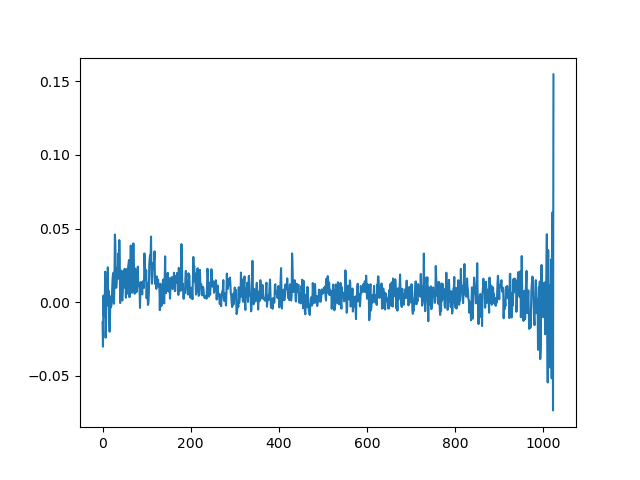

In [241]:
plt.figure()

plt.plot(sy_i)#.shape

In [197]:
exp='xppl1001021'
# run=61

In [198]:
ds = psana.MPIDataSource(f'exp={exp}:run={r}:smd')
detname = 'jungfrau1M_alcove'
det = psana.Detector(detname)

In [199]:
%%time

N=1000
for nevt,evt in enumerate(ds.events()):
    if nevt == N: 
        print('Loading done. Breaking.')
        break
    img = det.image(evt)
    if nevt == 0:
        print('Set up imgs array.')
        imgs = np.zeros(np.r_[N, img.shape])
    imgs[nevt] = det.image(evt)

Set up imgs array.
Loading done. Breaking.
CPU times: user 5min 14s, sys: 4.11 s, total: 5min 18s
Wall time: 5min 22s


In [215]:
mean_im = imgs.mean(axis=0)

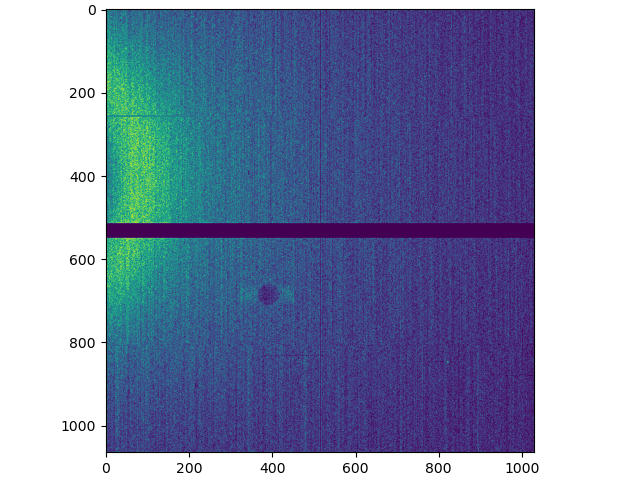

In [201]:
imfig,imax=plt.subplots(constrained_layout=True)

imax.imshow(mean_im.clip(0,2e2))

In [202]:
mask = np.zeros(mean_im.shape)

In [203]:
stds=imgs.std(axis=0)

(array([[ 40.,   3.,  20., ...,  31.,   4.,   0.],
        [ 41.,   8.,  68., ...,   3.,   0.,   0.],
        [ 40.,   8., 105., ...,   0.,   0.,   0.],
        ...,
        [ 43., 400., 565., ...,   0.,   0.,   0.],
        [293., 265., 443., ...,   0.,   0.,   0.],
        [ 41., 195., 634., ...,   0.,   0.,   0.]]),
 array([0.        , 0.22146176, 0.44292352, 0.66438528, 0.88584704,
        1.1073088 , 1.32877056, 1.55023232, 1.77169408, 1.99315584,
        2.2146176 ]),
 <a list of 1030 BarContainer objects>)

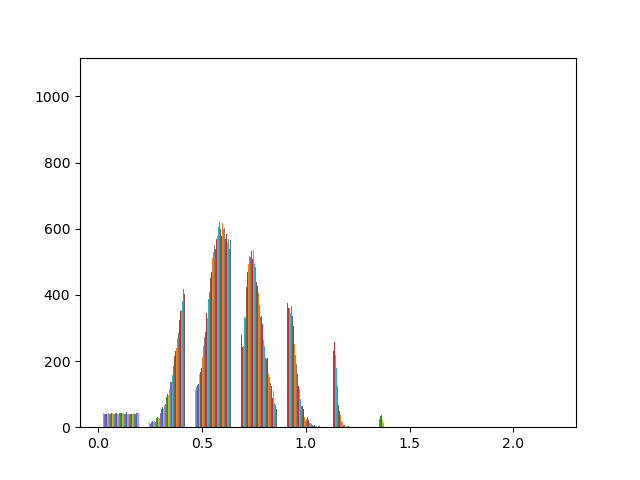

In [204]:
plt.figure()
plt.hist(stds)

In [205]:
mask[stds<1/4]=1

In [206]:
hi_q_mask = (ai.qArray()/10>4).astype(np.float32)
lo_q_mask = (ai.qArray()/10<1.2).astype(np.float32)
mask+=hi_q_mask+lo_q_mask

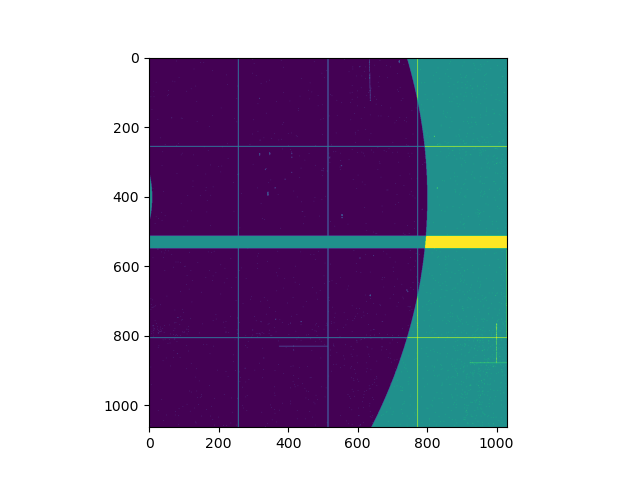

In [207]:
plt.figure()
plt.imshow(mask)

In [208]:
scriptmask=np.load('../shared/mask/mask_jungfrau_calib_231104.npy')

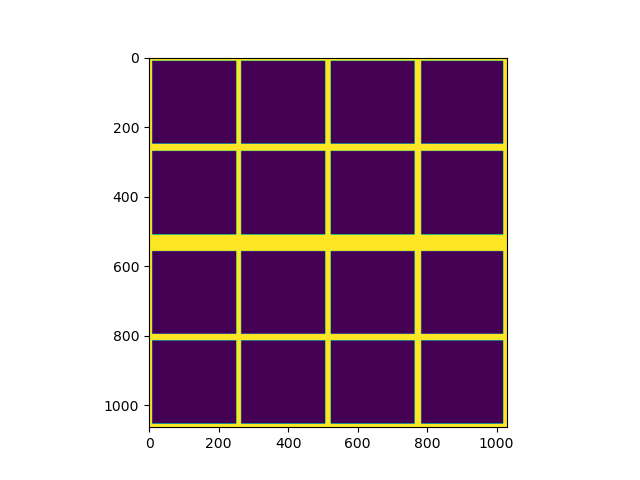

In [209]:
plt.figure()

plt.imshow(scriptmask)

In [210]:
unit='q_A^-1'
yl=r'$ I(q)$'
xl=r'$q\quad \left[\mathrm{\AA^{-1}}\right]$'

In [216]:
q,i=ai.integrate1d(mean_im,1024,unit=unit,mask=scriptmask)

[Text(0.5, 1.0, 'Run 100, first 1000 images.'),
 Text(0, 0.5, '$ I(q)$'),
 Text(0.5, 0, '$q\\quad \\left[\\mathrm{\\AA^{-1}}\\right]$')]

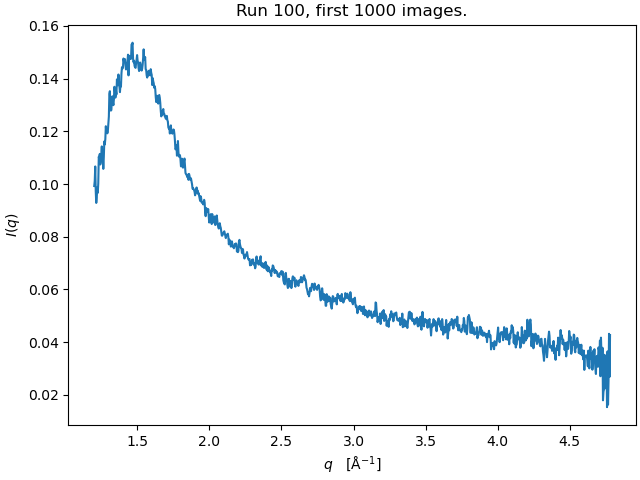

In [217]:
ifig,iax = plt.subplots(constrained_layout=True)

iax.plot(q,i)
iax.set(title='Run '+str(r)+f', first {N} images.',ylabel=yl,xlabel=xl)